In [1]:
import pywt
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
def remove_outliers(df, threshold=3):
    z_scores = stats.zscore(df)
    abs_z_scores = abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)  # Adjust the threshold as needed (e.g., 3 standard deviations)
    df_filtered = df[filtered_entries]
    df_filtered.reset_index(drop=True, inplace=True)
    return df_filtered

# Ground truth

Load the data and convert values to SI system for easy interpretation. Also, calculate $Z$ from $\rho$ and $v$, and use that Z values to calculate the reflection coefficient $r$. The seismogram $s$ (wavelet convolved with reflection coefficients) is calculated as well.

In [3]:
path_data = "D:\\Users\\serfe\\Desktop\\Maestria geofísica\\1- Semestre 202302\\Inversión sísmica\\0 - Tasks\\Task 1\\data.xlsx"
df = pd.read_excel(path_data)

In [4]:
print(f'Length of unfiltered (raw) data (without outliers): {len(df)}')

Length of unfiltered (raw) data (without outliers): 2999


In [5]:
# Remove outliers from all columns
df = remove_outliers(df[['DEPT', 'RHOB', 'DT']], threshold=3)
print(f'Length of filtered data (without outliers): {len(df)}')

Length of filtered data (without outliers): 2977


In [6]:


# convert all to internation units system
print('Original units are: DT [microseconds/ft], DEPT[ft], RHOB[g/cm^3]')
print('Converted units are: DT [s/m], DEPT[m], RHOB[kg/m^3]')
df['DT'] = df['DT']/((1*10**6)*0.3048) # s/m
df['RHOB'] = df['RHOB']*(1000000/1000) # kg/m^3
df['DEPT'] = df['DEPT']*0.3048 # m

# calculate Acoustic Impedance
df['Z'] = (1/(df.DT))*df.RHOB # kg/(s*m^2)

# calculate reflection coefficients
temp = []
for i in range(1, len(df.Z)):
    num = df['Z'][i]-df['Z'][i-1]
    den = df['Z'][i]+df['Z'][i-1]
    val = num/den
    temp.append(val)
    if i == len(df.Z)-1:
        temp.append(temp[-1])
        
df['r'] = temp

# calculate convolved signal: wavelet + reflectivity profile
points = 100
a = 5
vec2 = signal.ricker(points, a)
df['s'] = np.convolve(df.r, vec2, 'same')

Original units are: DT [microseconds/ft], DEPT[ft], RHOB[g/cm^3]
Converted units are: DT [s/m], DEPT[m], RHOB[kg/m^3]


In [7]:
df

DEPT     RHOB        DT             Z         r         s
0      388.3152  2071.85  0.000490  4.230928e+06 -0.057333 -0.024599
1      388.6200  1996.38  0.000529  3.772090e+06  0.007662 -0.026433
2      388.9248  2041.96  0.000533  3.830341e+06  0.009984 -0.026825
3      389.2296  2041.11  0.000522  3.907599e+06  0.008274 -0.025788
4      389.5344  2042.97  0.000514  3.972801e+06  0.005335 -0.023268
...         ...      ...       ...           ...       ...       ...
2972  1294.1808  2339.76  0.000333  7.030310e+06  0.013507  0.030311
2973  1294.4856  2370.43  0.000328  7.222824e+06 -0.015856  0.039186
2974  1294.7904  2363.05  0.000338  6.997351e+06  0.000242  0.046577
2975  1295.0952  2342.78  0.000335  7.000744e+06  0.069938  0.050985
2976  1295.4000  2386.69  0.000296  8.053610e+06  0.069938  0.051134

[2977 rows x 6 columns]

This is the wavelet we are going to use for the convolution.

Text(0.5, 1.0, 'Ricker wavelet')

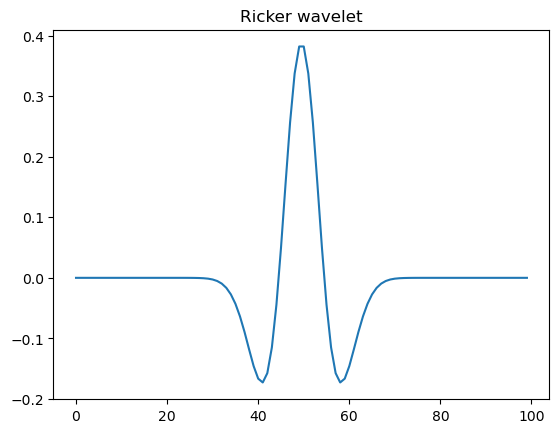

In [8]:
plt.plot(vec2)
plt.title('Ricker wavelet')

$DT$ is the amount of time for a wave to travel a certain distance, proportional to the reciprocal of velocity, typically measured in microseconds per foot by an acoustic log and simbolyzed by $t$ or $DT$. P-wave interval transit times for common sedimentary rock types range from 43 (dolostone) to 160 (unconsolidated shales) microseconds per foot, and can be distinguished from measurements of steel casing, which has a consistent transit time of 57 microseconds per foot.

Naturally, when increasing depth, $v$ and $\rho$ increase. As a consequence of velocity increase, the interval transit time, $DT$, decreaces because it is the reciprocal of the velocity.

Text(0.5, 1.0, 'Signal')

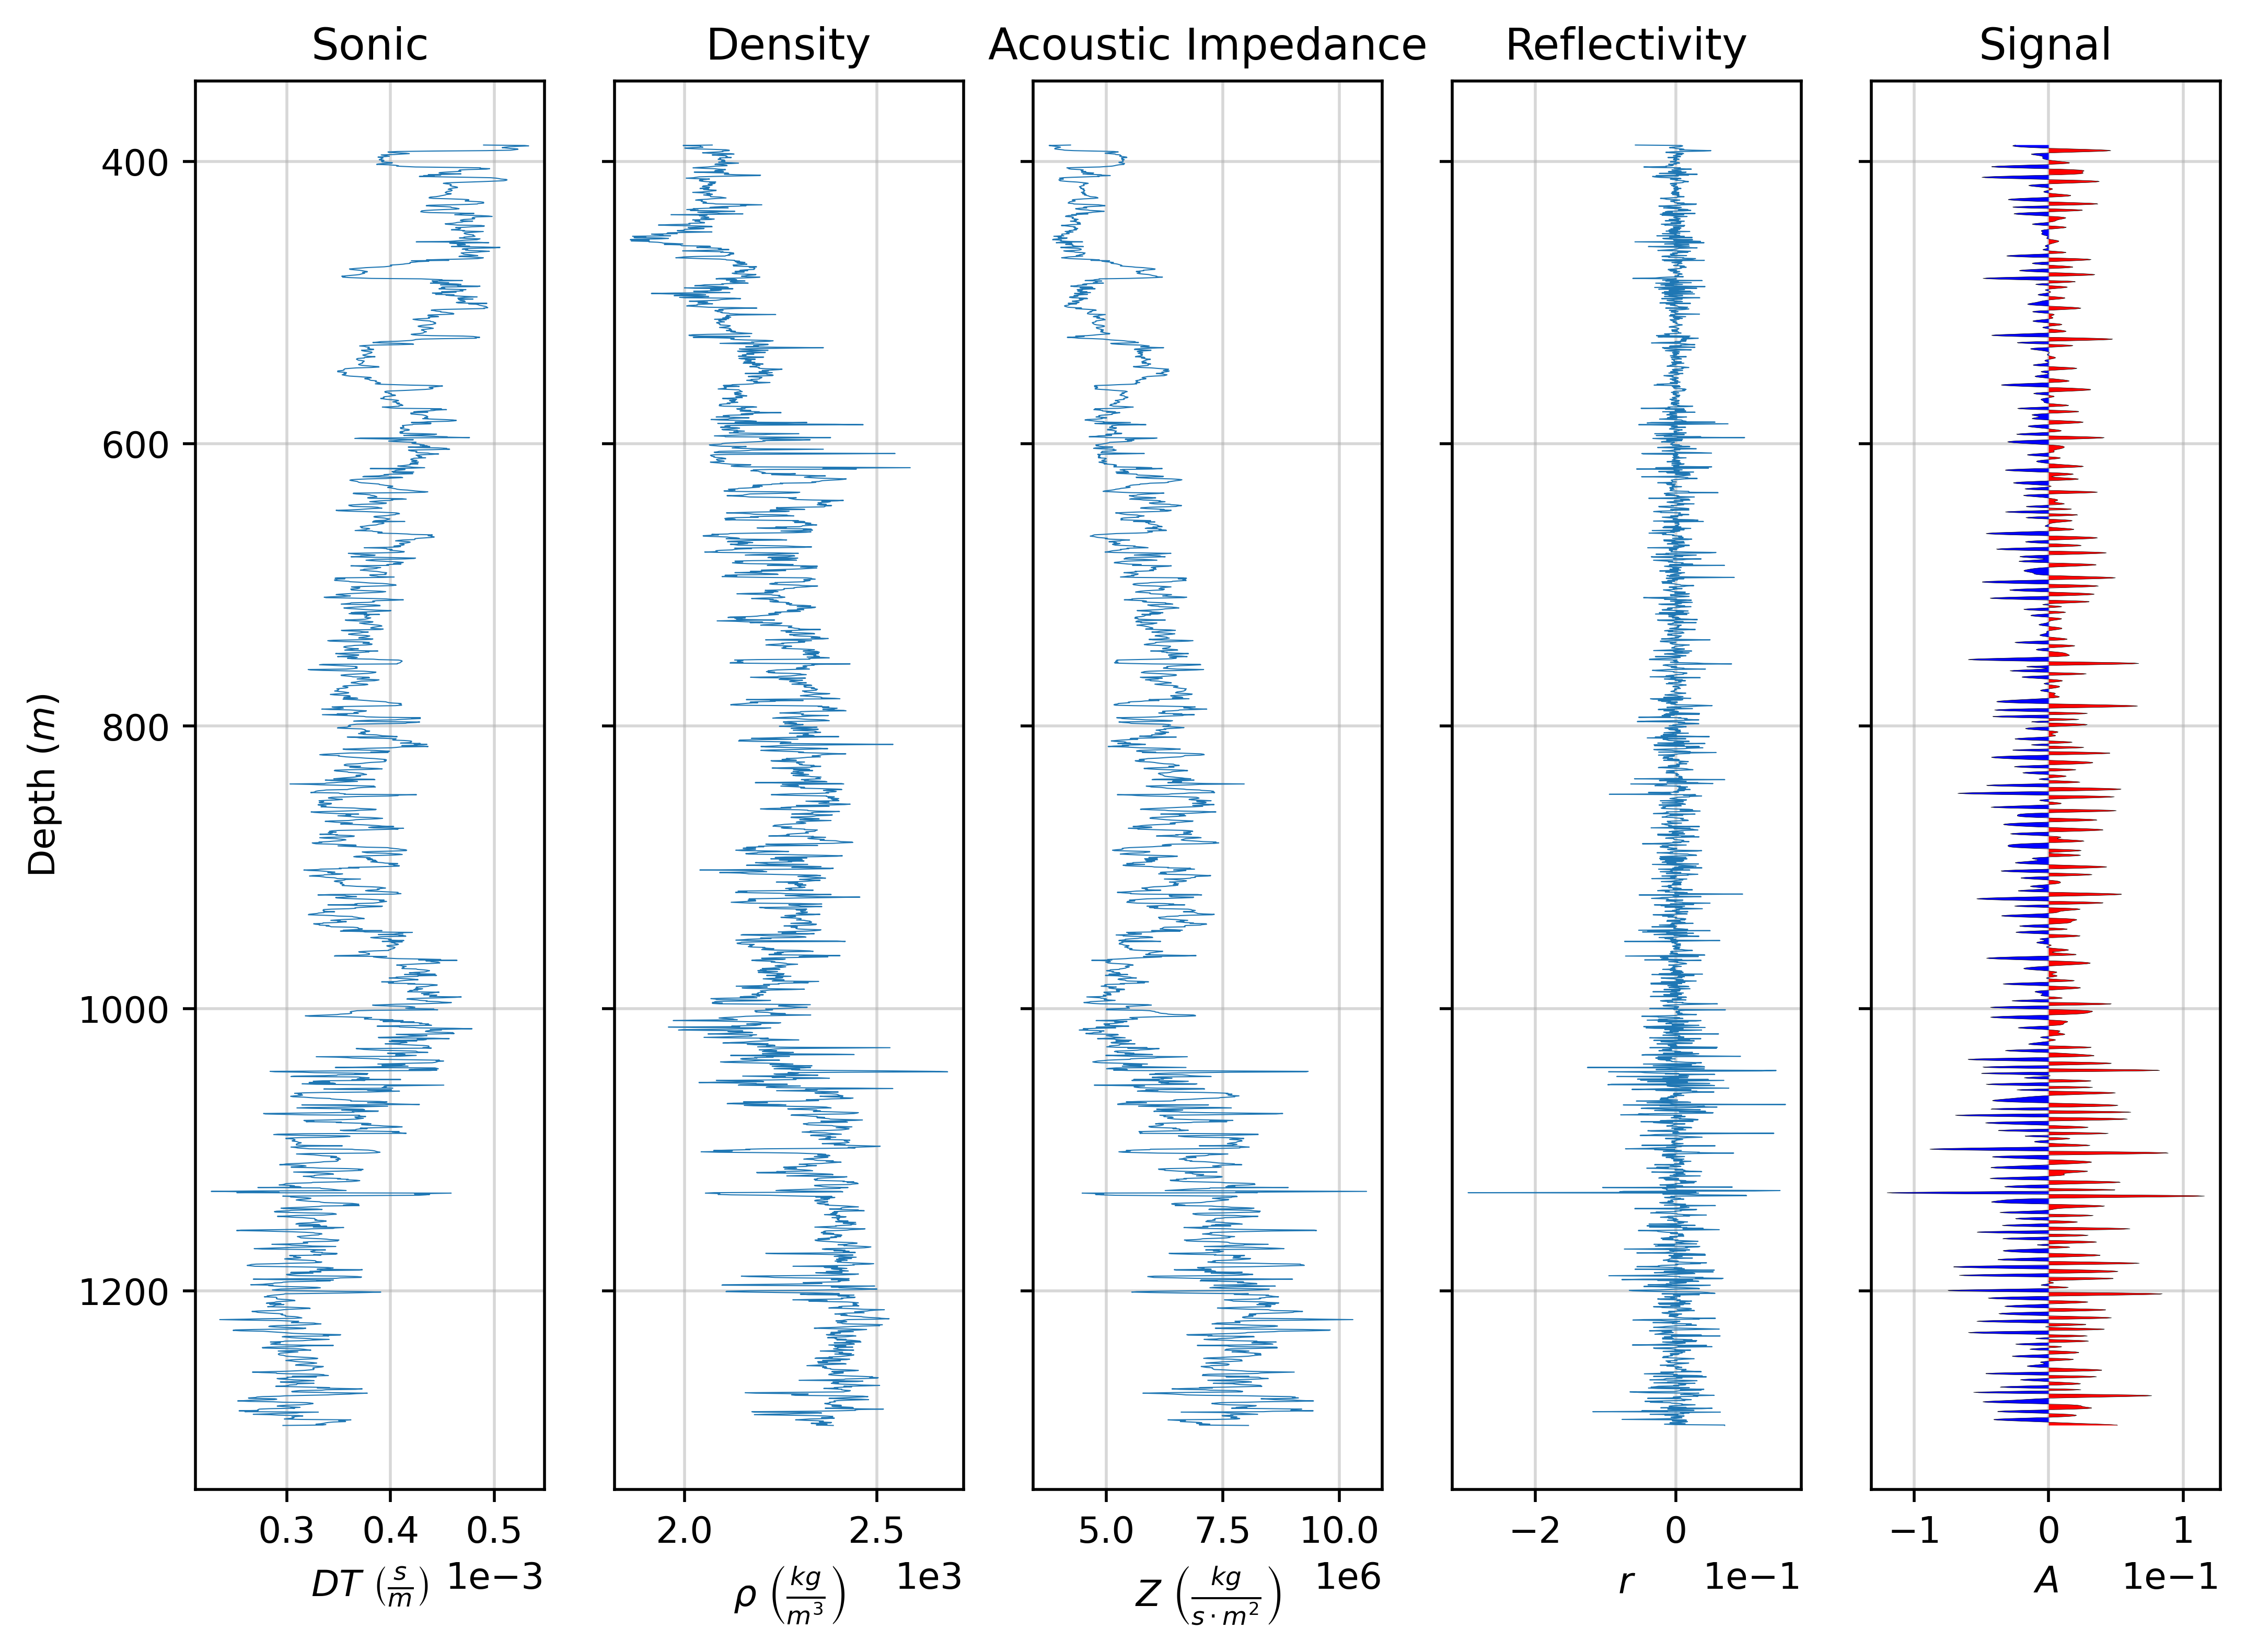

In [9]:
fig, ax = plt.subplots(1,5, figsize=(10,7), sharey=True, dpi=500)
lw=.3
ax[0].plot(df.DT, df.DEPT, linewidth=lw)
ax[0].set_xlabel(r'$DT$ $\left(\frac{s}{m}\right)$')
ax[0].set_ylabel(r'Depth ($m$)')
ax[0].grid(alpha=.5)
ax[0].invert_yaxis()
ax[0].set_axisbelow(True)
ax[0].ticklabel_format(style='sci', axis='x', scilimits=(-3,-3))
ax[0].set_title('Sonic')

ax[1].plot(df.RHOB, df.DEPT, linewidth=lw)
ax[1].set_xlabel(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
ax[1].grid(alpha=.5)
ax[1].set_axisbelow(True)
ax[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
ax[1].set_title('Density')

ax[2].plot(df.Z, df.DEPT, linewidth=lw)
ax[2].set_xlabel(r'$Z$ $\left(\frac{kg}{s \cdot m^2}\right)$')
ax[2].grid(alpha=.5)
ax[2].set_axisbelow(True) 
ax[2].ticklabel_format(style='sci', axis='x', scilimits=(6,6))
ax[2].set_title('Acoustic Impedance')

ax[3].plot(df.r, df.DEPT, linewidth=lw)
ax[3].set_xlabel(r'$r$')
ax[3].grid(alpha=.5)
ax[3].set_axisbelow(True)
ax[3].ticklabel_format(style='sci', axis='x', scilimits=(-1,-1))
ax[3].set_title('Reflectivity')

ax[4].plot(df.s, df.DEPT, linewidth=.1, color='k')
ax[4].set_xlabel(r'$A$')
ax[4].grid(alpha=.5)
ax[4].set_axisbelow(True)
ax[4].fill_betweenx(df.DEPT, x1=df.s, x2=0, where=df.s<=0, color='blue', linewidth=0)
ax[4].fill_betweenx(df.DEPT, x1=df.s, x2=0, where=df.s>0, color='red', linewidth=0)
ax[4].ticklabel_format(style='sci', axis='x', scilimits=(-1,-1))
ax[4].set_title('Signal')

# Real data + Random noise

Now let's re-calculate z, rho and v by the three available methods by taking not the original reflectivity coefficients (without noise) but the modified reflectivity coefficients (with a random uniform noise).
 https://www.subsurfwiki.org/wiki/Gardner%27s_equation#:~:text=Gardner%20showed%20that%3A,P%7D%20%7D%5E%7B%5Cbeta%20%7D%7D&text=Assuming%20this%2C%20and%20using%20units,%7Bm%7D%20%5E%7B3%7D%7D

In [10]:
def give_params():
    
    alpha = 310
    beta = 0.25
        
    return alpha, beta

def calc_rho(Vp):
    
    alpha, beta = give_params()   
    rho = alpha*Vp**beta
        
    return rho

def calc_vp(Z):

    alpha, beta = give_params() # parms of the Gardner relation
    vp = (Z/alpha)**(1/(beta+1))
    
    return vp

1) Method 1

$Z_i = Z_0\prod \frac{1+r_i}{1-r_i}$

2) Method 2, $|r|<0.3$

$Z(t_m)=Z(t_0)e^{2\sum_{t=t_0}^{t_m}r(t)\Delta t}$

3) Method 3, $|r|<0.1$

$Z(t_m)=2Z_0\sum_{t=t_0}^{t_m}r(t_m)\Delta t$


In [11]:
# add some noise to real r
avg = abs(np.mean(df.r))/.06
noise = np.random.uniform(low=-avg, high=avg, size=(len(df.r)))
df['r_prim'] = df.r + noise

Text(0.5, 1.0, 'Uniform noise')

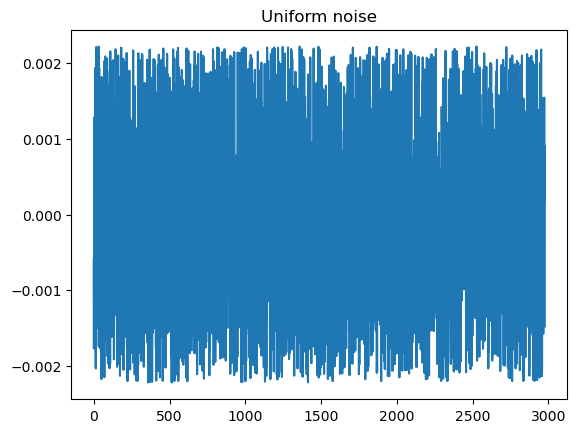

In [12]:
plt.plot(noise)
plt.title('Uniform noise')

# Method 1 - Recursive approach

In [13]:
z_prim_m1 = []

z0 = df['Z'].iloc[0]
cociente = 1

# calculate Z
for i in range(len(df.r_prim)-1):
    
    cociente *= (1+df.r_prim[i])/(1-df.r_prim[i])
    z_prim_m1.append(cociente)

z_prim_m1.append(z_prim_m1[-1])
z_prim_m1 = np.array(z_prim_m1)*z0
df['Z_m1'] = z_prim_m1

# calculate Vp
Vp_prim_m1 = calc_vp(df.Z_m1) # this is calculated in international units
df['Vp_m1'] = Vp_prim_m1

# calculate rho
rho_prim_m1 = calc_rho(df.Vp_m1) # this is given in g/cm^3
df['rho_m1'] = np.array(rho_prim_m1)

# calculate convolved signal: wavelet + reflectivity profile
points = 100
a = 5
vec2 = signal.ricker(points, a)
df['s_prim'] = np.convolve(df.r_prim, vec2, 'same')

# Method 2, |r| < 0.3

In [14]:
z_m2 = []

z0 = df['Z'].iloc[0]

# calculate Z
for i in range(len(df.r_prim)-1):
    
    z_temp = z0*np.exp(2*np.sum(df.r_prim[:i+1]))
    z_m2.append(z_temp)

z_m2.append(z_m2[-1])
df['Z_m2'] = z_m2

# calculate Vp
Vp_m2 = calc_vp(df.Z_m2) # this is calculated in international units
df['Vp_m2'] = Vp_m2

# calculate rho
rho_m2 = calc_rho(df.Vp_m2) # this is given in g/cm^3
df['rho_m2'] = np.array(rho_m2)

In [15]:
df

DEPT     RHOB        DT             Z         r         s  \
0      388.3152  2071.85  0.000490  4.230928e+06 -0.057333 -0.024599   
1      388.6200  1996.38  0.000529  3.772090e+06  0.007662 -0.026433   
2      388.9248  2041.96  0.000533  3.830341e+06  0.009984 -0.026825   
3      389.2296  2041.11  0.000522  3.907599e+06  0.008274 -0.025788   
4      389.5344  2042.97  0.000514  3.972801e+06  0.005335 -0.023268   
...         ...      ...       ...           ...       ...       ...   
2972  1294.1808  2339.76  0.000333  7.030310e+06  0.013507  0.030311   
2973  1294.4856  2370.43  0.000328  7.222824e+06 -0.015856  0.039186   
2974  1294.7904  2363.05  0.000338  6.997351e+06  0.000242  0.046577   
2975  1295.0952  2342.78  0.000335  7.000744e+06  0.069938  0.050985   
2976  1295.4000  2386.69  0.000296  8.053610e+06  0.069938  0.051134   

        r_prim          Z_m1        Vp_m1       rho_m1    s_prim  \
0    -0.057930  3.767577e+06  1852.509246  2033.769780 -0.025073   
1     0.005894  3.812252e+06  1870.061707  2038.570232 -0.026857   
2     0.011265  3.899121e+06  1904.074910  2047.777191 -0.027158   
3     0.009207  3.971587e+06  1932.332588  2055.332849 -0.026018   
4     0.005571  4.016088e+06  1949.634614  2059.918322 -0.023415   
...        ...           ...          ...          ...       ...   
2972  0.013675  6.089100e+06  2719.901179  2238.721011  0.031911   
2973 -0.014311  5.917277e+06  2658.325707  2225.941475  0.040585   
2974 -0.001243  5.902581e+06  2653.042652  2224.834712  0.047717   
2975  0.070846  6.802700e+06  2972.047300  2288.893696  0.051829   
2976  0.070799  6.802700e+06  2972.047300  2288.893696  0.051674   

              Z_m2        Vp_m2       rho_m2  
0     3.768067e+06  1852.701715  2033.822604  
1     3.812747e+06  1870.255796  2038.623124  
2     3.899623e+06  1904.271077  2047.829932  
3     3.972096e+06  1932.530861  2055.385571  
4     4.016603e+06  1949.834482  2059.971114  
...            ...          ...          ...  
2972  6.148210e+06  2741.003471  2243.050701  
2973  5.974731e+06  2678.954455  2230.247321  
2974  5.959892e+06  2673.630407  2229.138418  
2975  6.867118e+06  2994.540872  2293.212261  
2976  6.867118e+06  2994.540872  2293.212261  

[2977 rows x 14 columns]

# Method 3, |r| < 0.1

In [16]:
z_m3 = []

z0 = df['Z'].iloc[0]

# calculate Z
for i in range(len(df.r_prim)-1):

    z_temp = (2*z0)*np.sum(df.r_prim[:i+1])
    z_m3.append(z_temp)

z_m3.append(z_m3[-1])
df['Z_m3'] = z_m3

# calculate Vp
Vp_m3 = calc_vp(df.Z_m3) # this is calculated in international units
df['Vp_m3'] = Vp_m3

# calculate rho
rho_m3 = calc_rho(df.Vp_m3) # this is given in g/cm^3
df['rho_m3'] = np.array(rho_m3)

# Resultados

Text(0.5, 0.98, 'Ground truth')

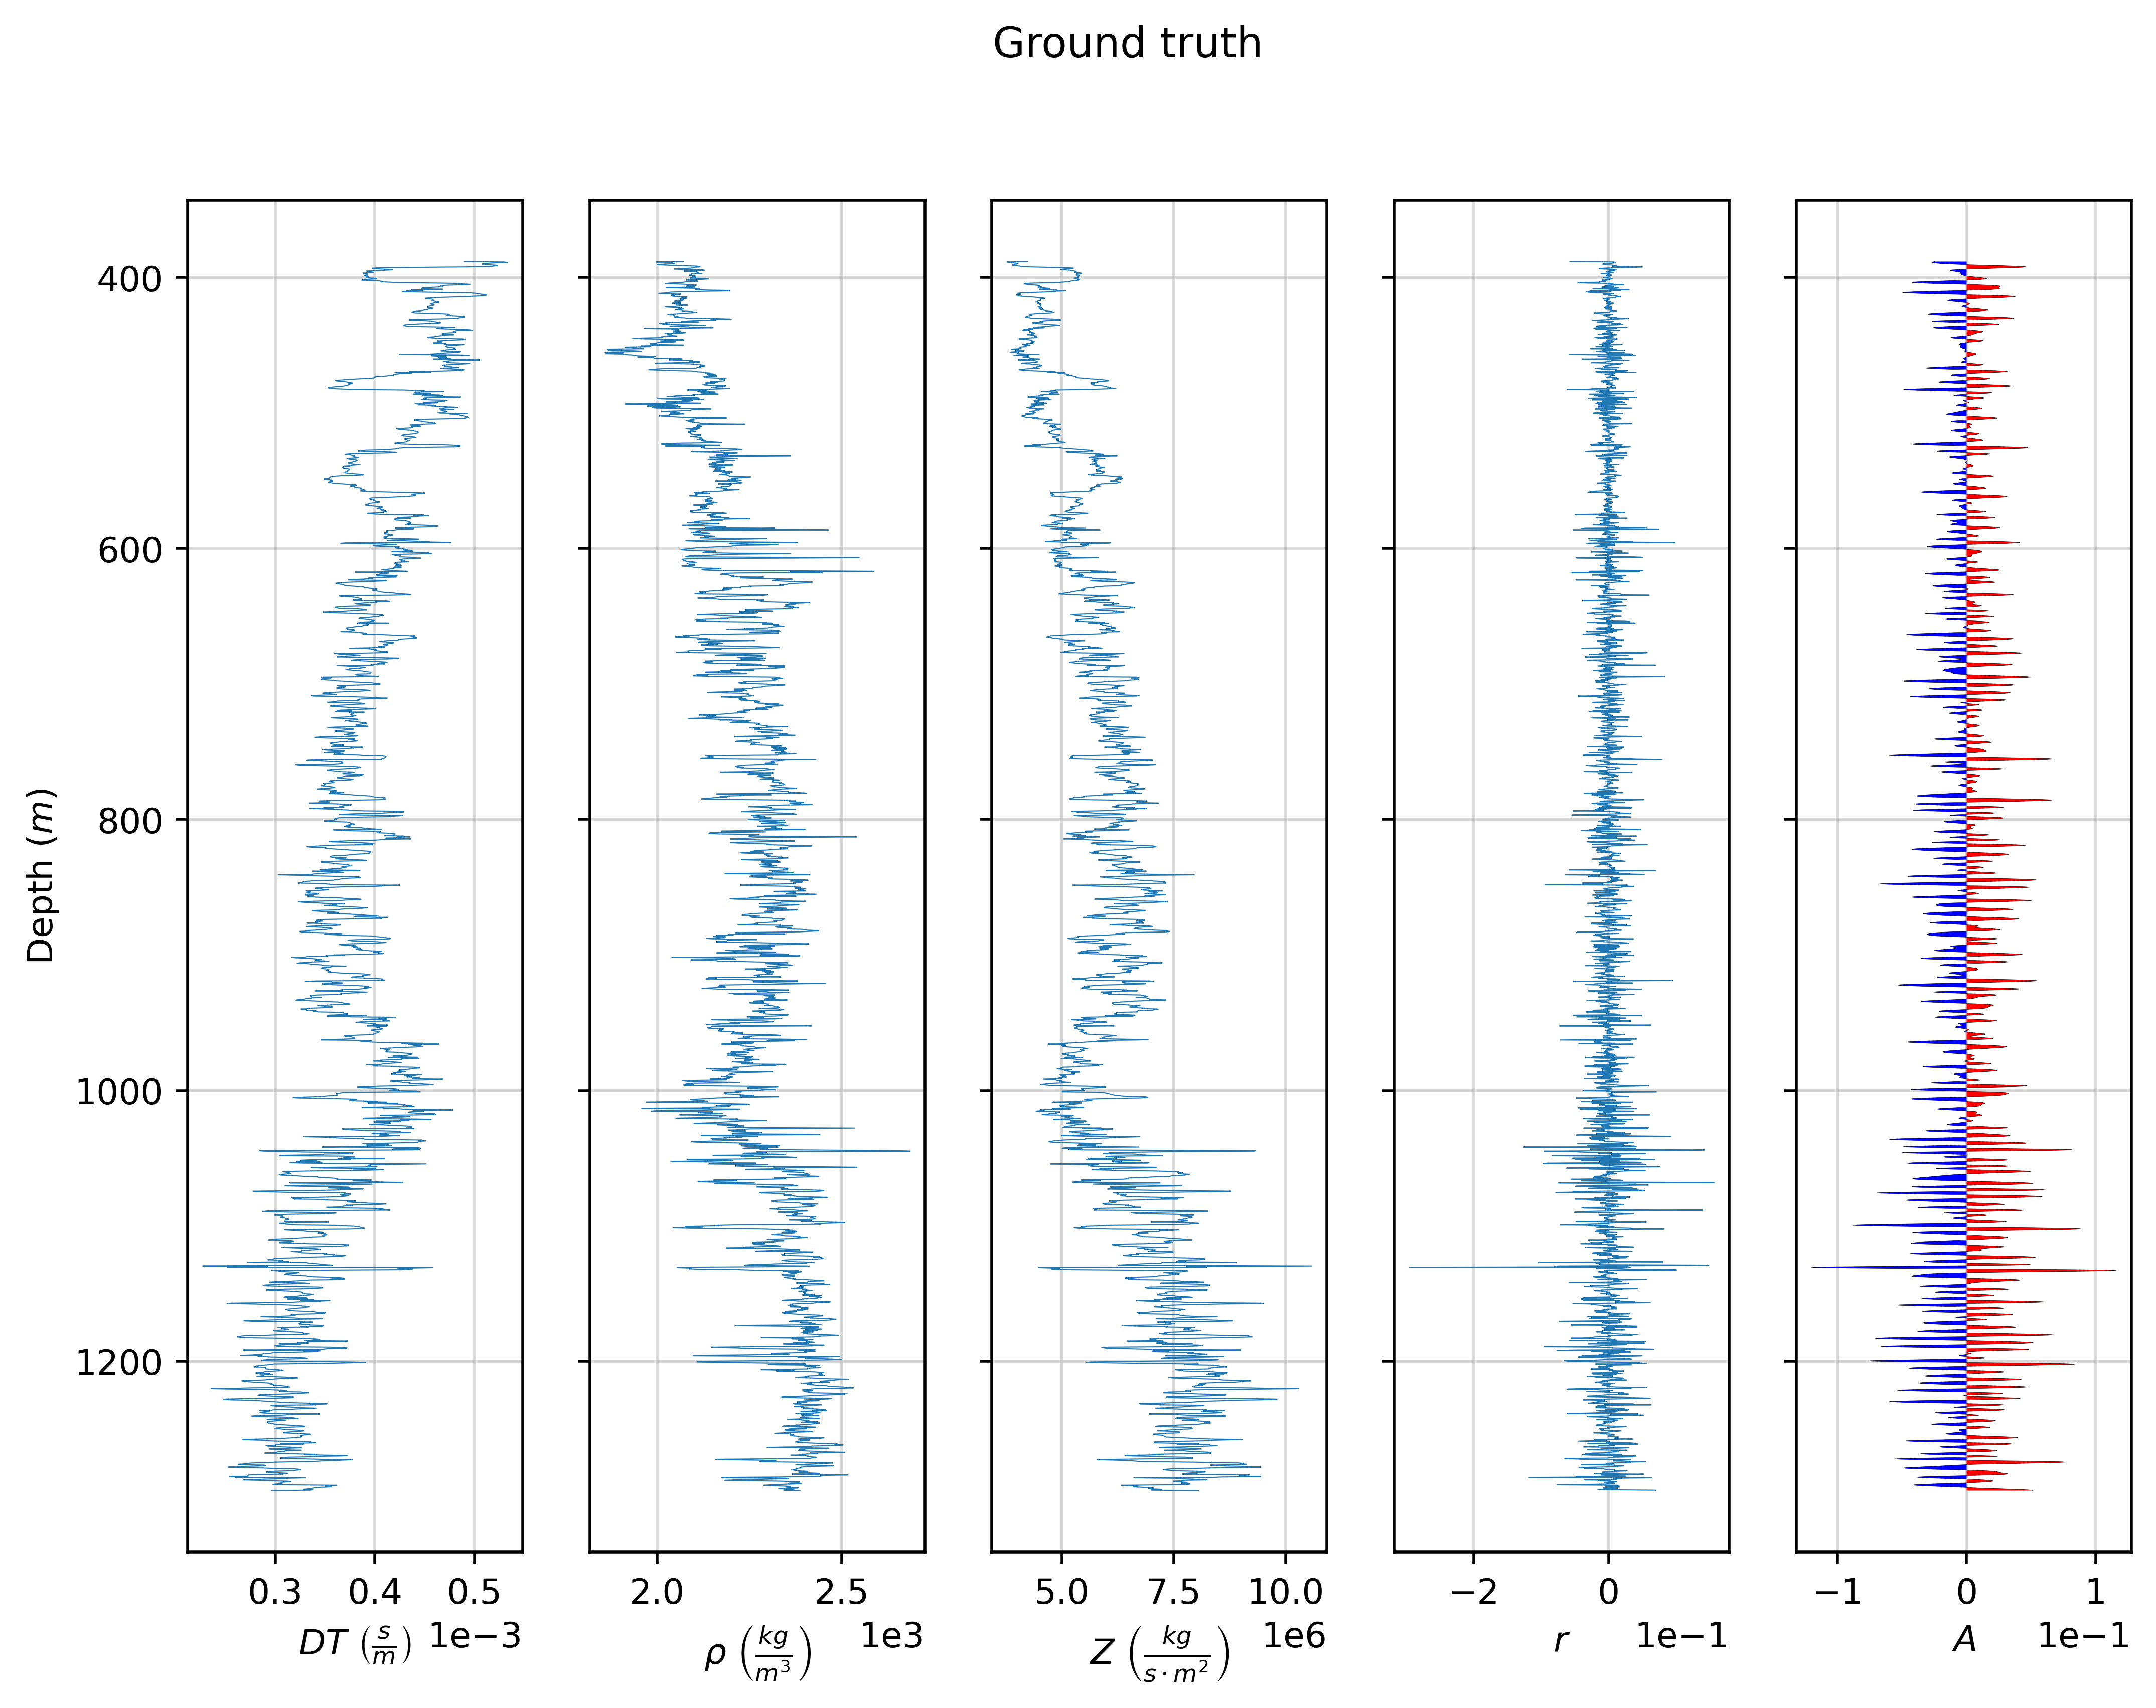

In [17]:
fig, ax = plt.subplots(1,5, figsize=(10,7), sharey=True, dpi=500)
lw=.3
ax[0].plot(df.DT, df.DEPT, linewidth=lw)
ax[0].set_xlabel(r'$DT$ $\left(\frac{s}{m}\right)$')
ax[0].set_ylabel(r'Depth ($m$)')
ax[0].grid(alpha=.5)
ax[0].invert_yaxis()
ax[0].set_axisbelow(True)
ax[0].ticklabel_format(style='sci', axis='x', scilimits=(-3,-3))

ax[1].plot(df.RHOB, df.DEPT, linewidth=lw)
ax[1].set_xlabel(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
ax[1].grid(alpha=.5)
ax[1].set_axisbelow(True)
ax[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

ax[2].plot(df.Z, df.DEPT, linewidth=lw)
ax[2].set_xlabel(r'$Z$ $\left(\frac{kg}{s \cdot m^2}\right)$')
ax[2].grid(alpha=.5)
ax[2].set_axisbelow(True) 
ax[2].ticklabel_format(style='sci', axis='x', scilimits=(6,6))

ax[3].plot(df.r, df.DEPT, linewidth=lw)
ax[3].set_xlabel(r'$r$')
ax[3].grid(alpha=.5)
ax[3].set_axisbelow(True)
ax[3].ticklabel_format(style='sci', axis='x', scilimits=(-1,-1))

ax[4].plot(df.s, df.DEPT, linewidth=.1, color='k')
ax[4].set_xlabel(r'$A$')
ax[4].grid(alpha=.5)
ax[4].set_axisbelow(True)
ax[4].fill_betweenx(df.DEPT, x1=df.s, x2=0, where=df.s<=0, color='blue', linewidth=0)
ax[4].fill_betweenx(df.DEPT, x1=df.s, x2=0, where=df.s>0, color='red', linewidth=0)
ax[4].ticklabel_format(style='sci', axis='x', scilimits=(-1,-1))

plt.suptitle('Ground truth')

Text(0.5, 0.98, 'Method 1, recursive inversion')

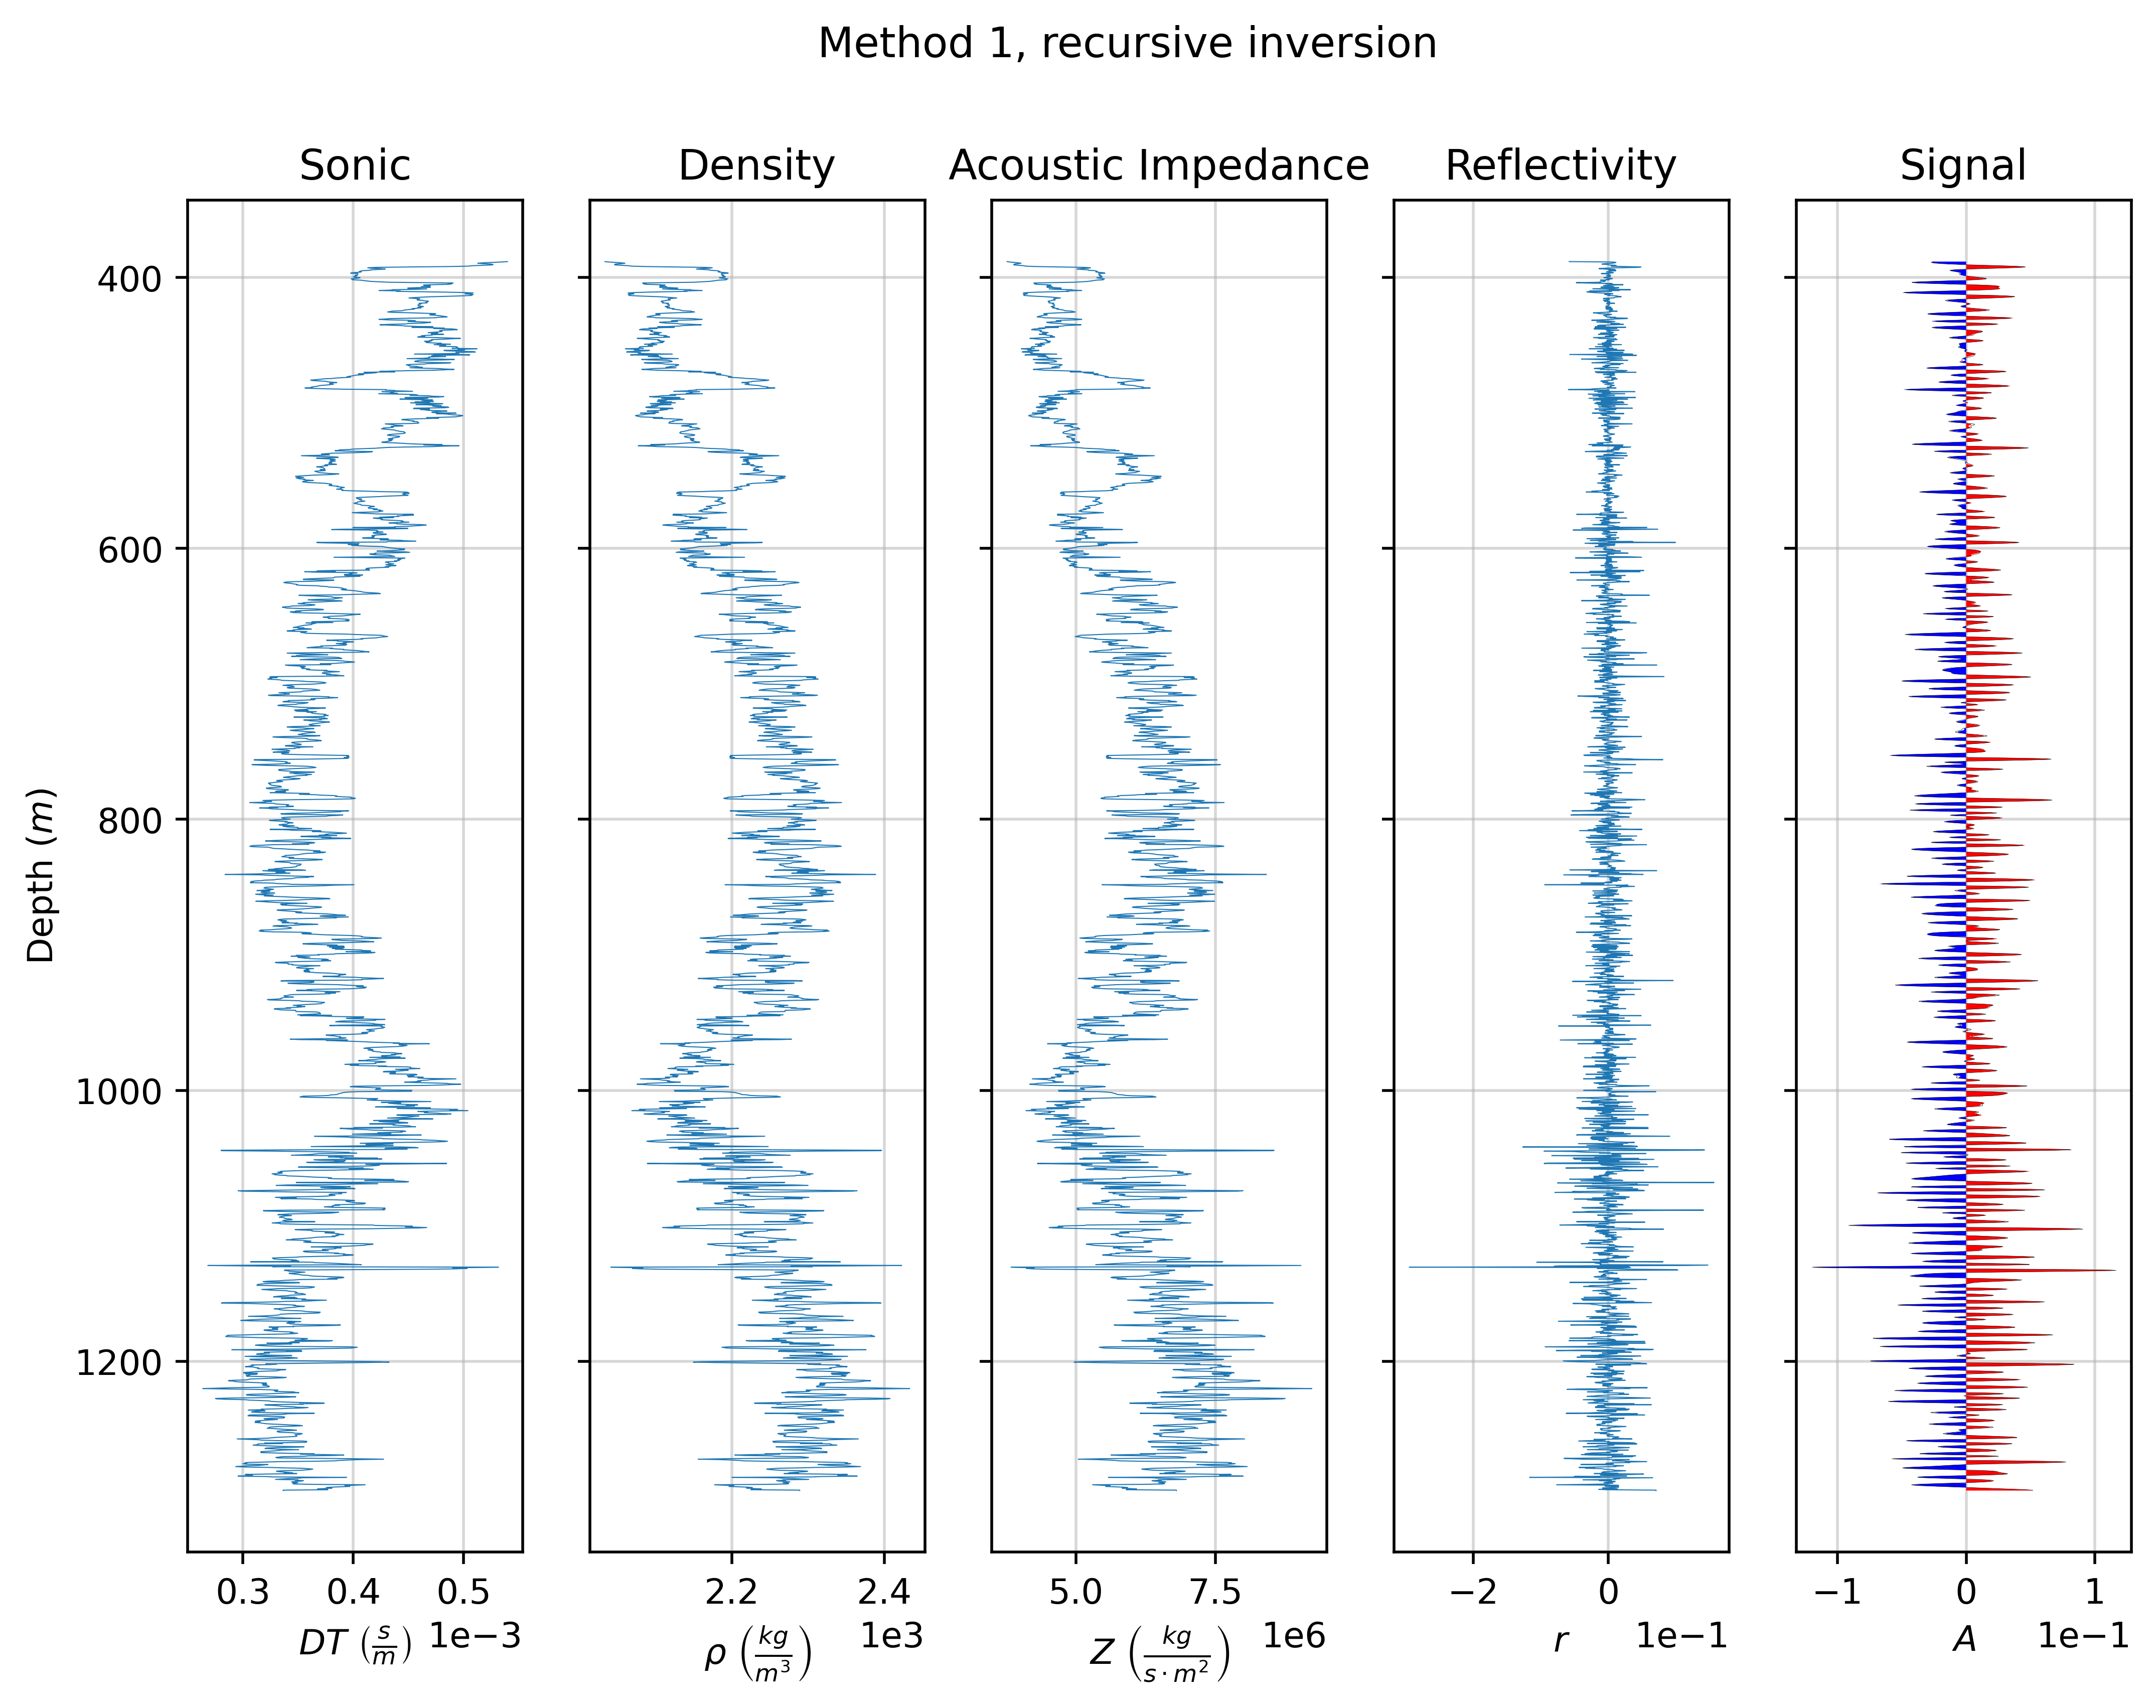

In [18]:
fig, ax = plt.subplots(1,5, figsize=(10,7), sharey=True, dpi=500)
lw=.3
ax[0].plot(1/df.Vp_m1, df.DEPT, linewidth=lw)
ax[0].set_xlabel(r'$DT$ $\left(\frac{s}{m}\right)$')
ax[0].set_ylabel(r'Depth ($m$)')
ax[0].grid(alpha=.5)
ax[0].invert_yaxis()
ax[0].set_axisbelow(True)
ax[0].ticklabel_format(style='sci', axis='x', scilimits=(-3,-3))

ax[1].plot(df.rho_m1, df.DEPT, linewidth=lw)
ax[1].set_xlabel(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
ax[1].grid(alpha=.5)
ax[1].set_axisbelow(True)
ax[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

ax[2].plot(df.Z_m1, df.DEPT, linewidth=lw)
ax[2].set_xlabel(r'$Z$ $\left(\frac{kg}{s \cdot m^2}\right)$')
ax[2].grid(alpha=.5)
ax[2].set_axisbelow(True) 
ax[2].ticklabel_format(style='sci', axis='x', scilimits=(6,6))

ax[3].plot(df.r_prim, df.DEPT, linewidth=lw)
ax[3].set_xlabel(r'$r$')
ax[3].grid(alpha=.5)
ax[3].set_axisbelow(True)
ax[3].ticklabel_format(style='sci', axis='x', scilimits=(-1,-1))

ax[4].plot(df.s_prim, df.DEPT, linewidth=.1, color='k')
ax[4].set_xlabel(r'$A$')
ax[4].grid(alpha=.5)
ax[4].set_axisbelow(True)
ax[4].fill_betweenx(df.DEPT, x1=df.s, x2=0, where=df.s<=0, color='blue', linewidth=0)
ax[4].fill_betweenx(df.DEPT, x1=df.s, x2=0, where=df.s>0, color='red', linewidth=0)
ax[4].ticklabel_format(style='sci', axis='x', scilimits=(-1,-1))


ax[0].set_title('Sonic')
ax[1].set_title('Density')
ax[2].set_title('Acoustic Impedance')
ax[3].set_title('Reflectivity')
ax[4].set_title('Signal')




plt.suptitle('Method 1, recursive inversion')

Text(0.5, 0.98, 'Method 2, |r| < 0.3')

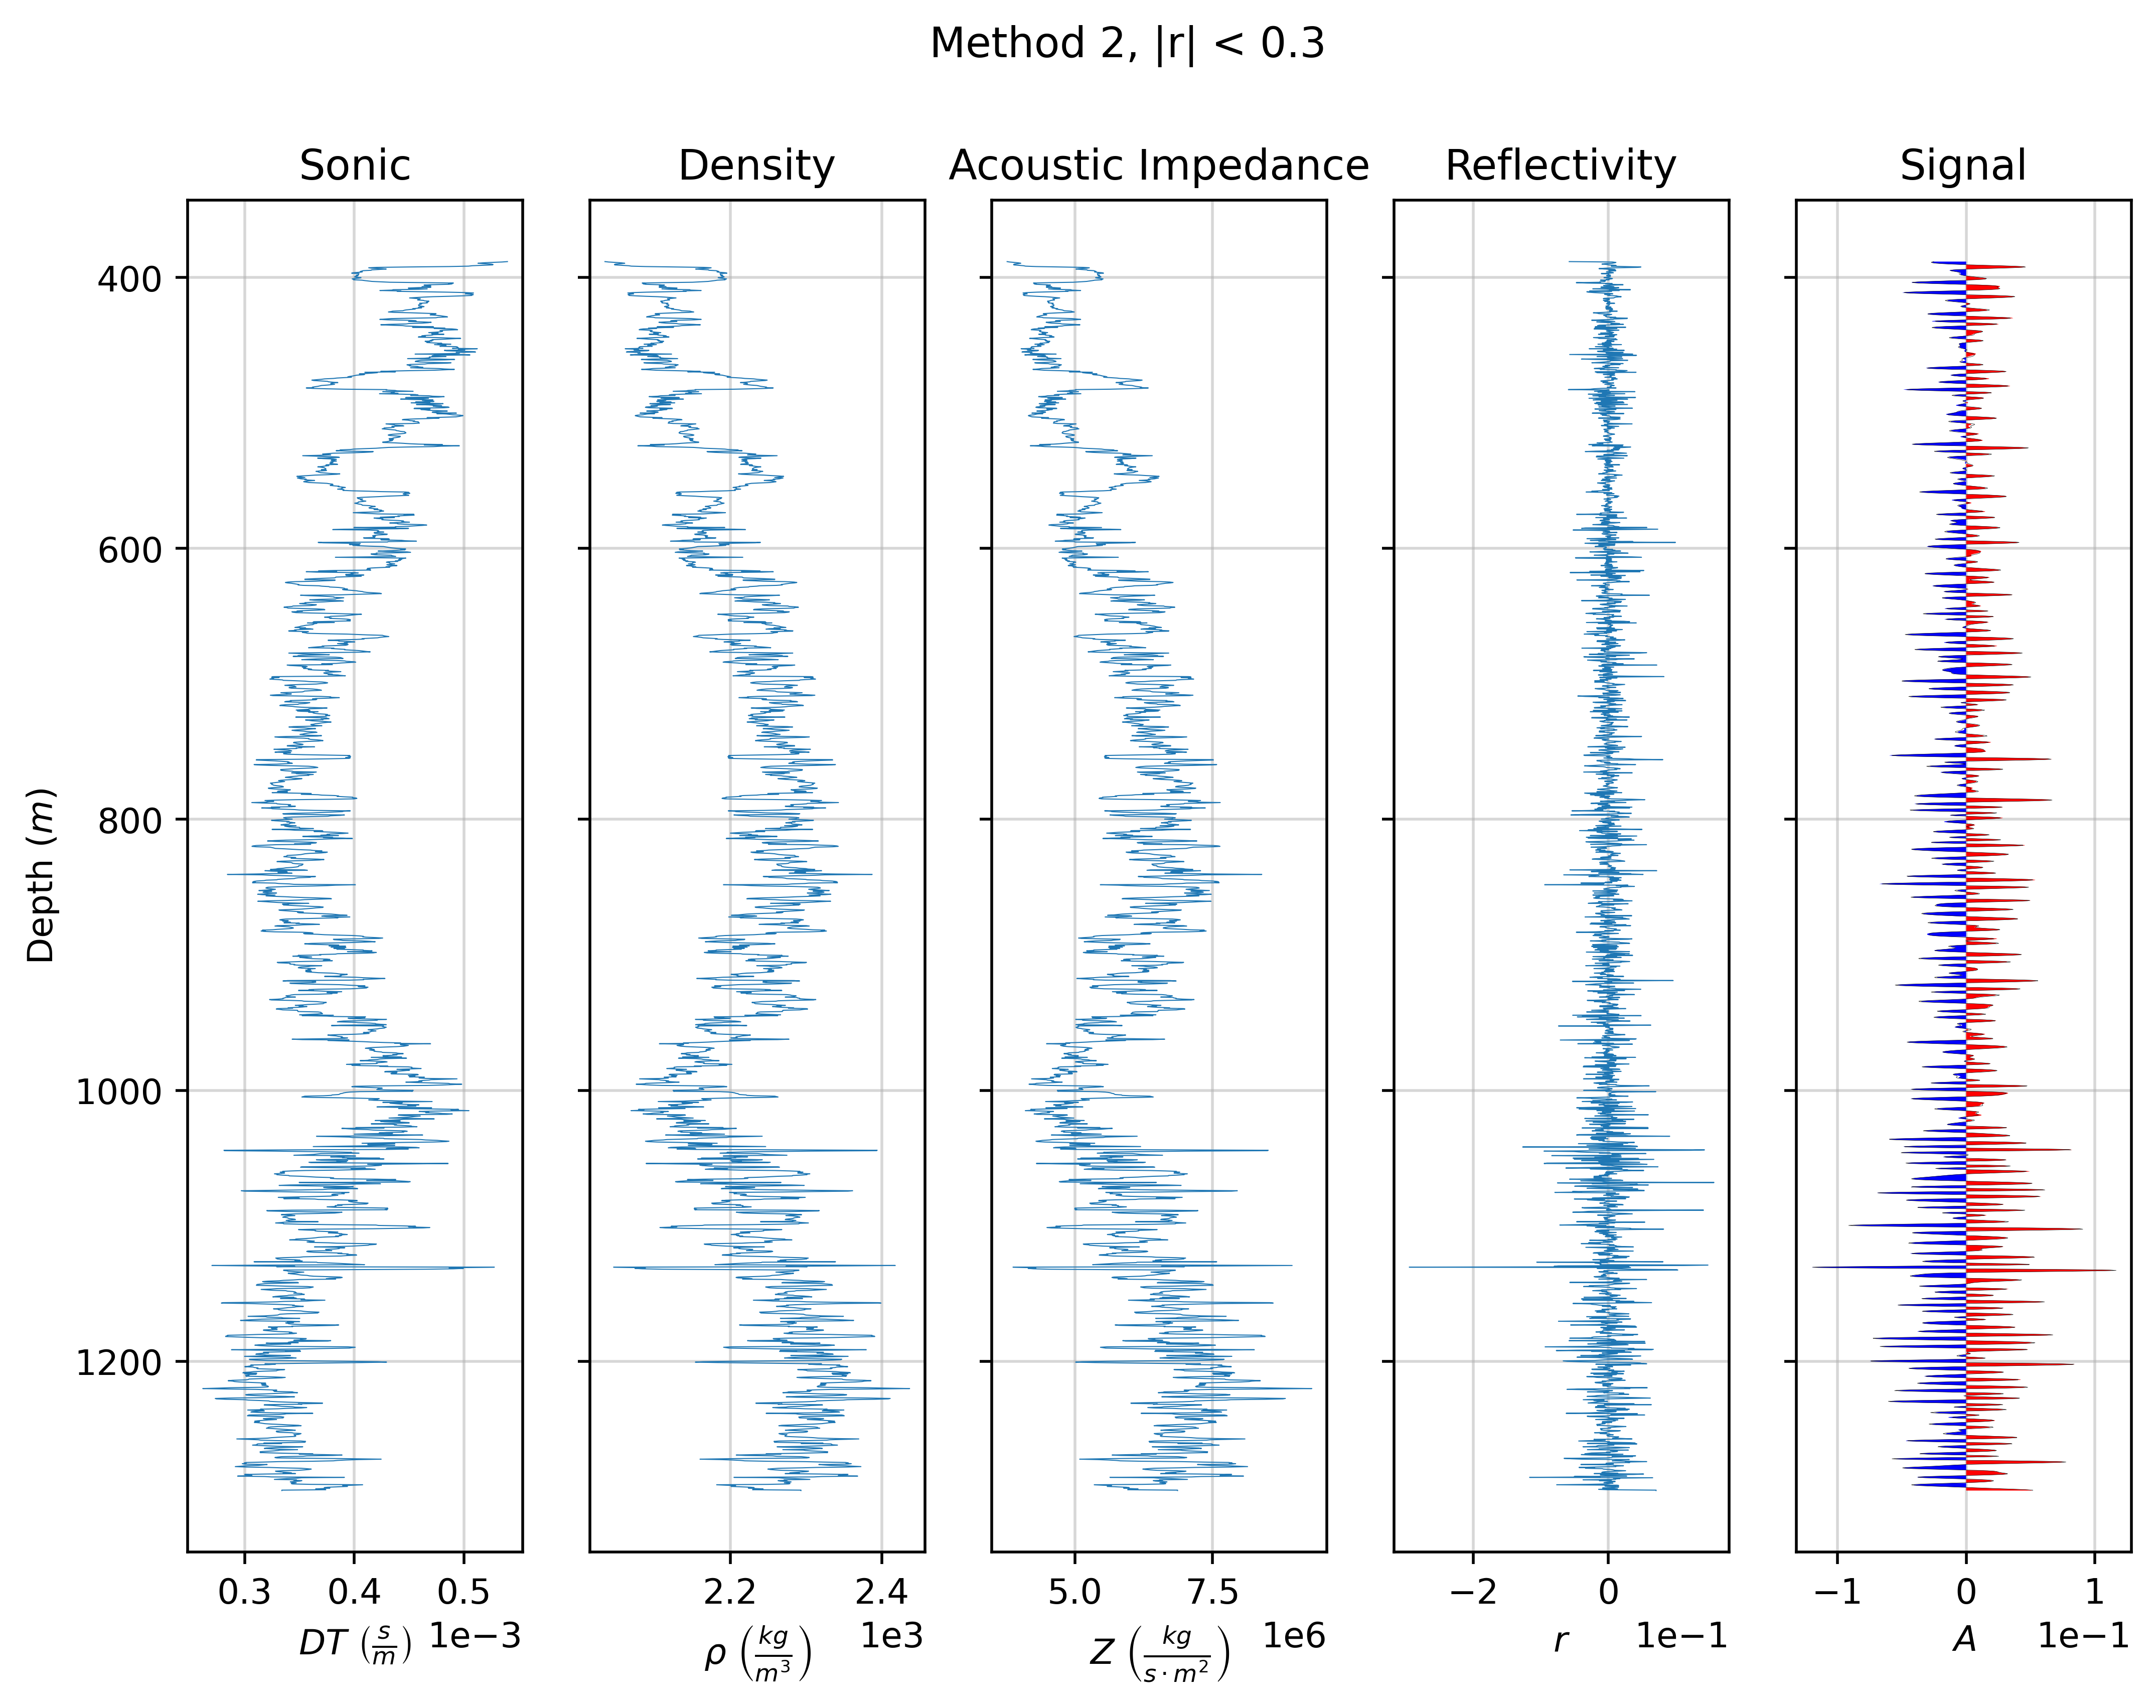

In [19]:
fig, ax = plt.subplots(1,5, figsize=(10,7), sharey=True, dpi=500)
lw=.3
ax[0].plot(1/df.Vp_m2, df.DEPT, linewidth=lw)
ax[0].set_xlabel(r'$DT$ $\left(\frac{s}{m}\right)$')
ax[0].set_ylabel(r'Depth ($m$)')
ax[0].grid(alpha=.5)
ax[0].invert_yaxis()
ax[0].set_axisbelow(True)
ax[0].ticklabel_format(style='sci', axis='x', scilimits=(-3,-3))

ax[1].plot(df.rho_m2, df.DEPT, linewidth=lw)
ax[1].set_xlabel(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
ax[1].grid(alpha=.5)
ax[1].set_axisbelow(True)
ax[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

ax[2].plot(df.Z_m2, df.DEPT, linewidth=lw)
ax[2].set_xlabel(r'$Z$ $\left(\frac{kg}{s \cdot m^2}\right)$')
ax[2].grid(alpha=.5)
ax[2].set_axisbelow(True) 
ax[2].ticklabel_format(style='sci', axis='x', scilimits=(6,6))

ax[3].plot(df.r_prim, df.DEPT, linewidth=lw)
ax[3].set_xlabel(r'$r$')
ax[3].grid(alpha=.5)
ax[3].set_axisbelow(True)
ax[3].ticklabel_format(style='sci', axis='x', scilimits=(-1,-1))

ax[4].plot(df.s_prim, df.DEPT, linewidth=.1, color='k')
ax[4].set_xlabel(r'$A$')
ax[4].grid(alpha=.5)
ax[4].set_axisbelow(True)
ax[4].fill_betweenx(df.DEPT, x1=df.s, x2=0, where=df.s<=0, color='blue', linewidth=0)
ax[4].fill_betweenx(df.DEPT, x1=df.s, x2=0, where=df.s>0, color='red', linewidth=0)
ax[4].ticklabel_format(style='sci', axis='x', scilimits=(-1,-1))

ax[0].set_title('Sonic')
ax[1].set_title('Density')
ax[2].set_title('Acoustic Impedance')
ax[3].set_title('Reflectivity')
ax[4].set_title('Signal')

plt.suptitle('Method 2, |r| < 0.3')

Text(0.5, 0.98, 'Method 3, |r| < 0.1')

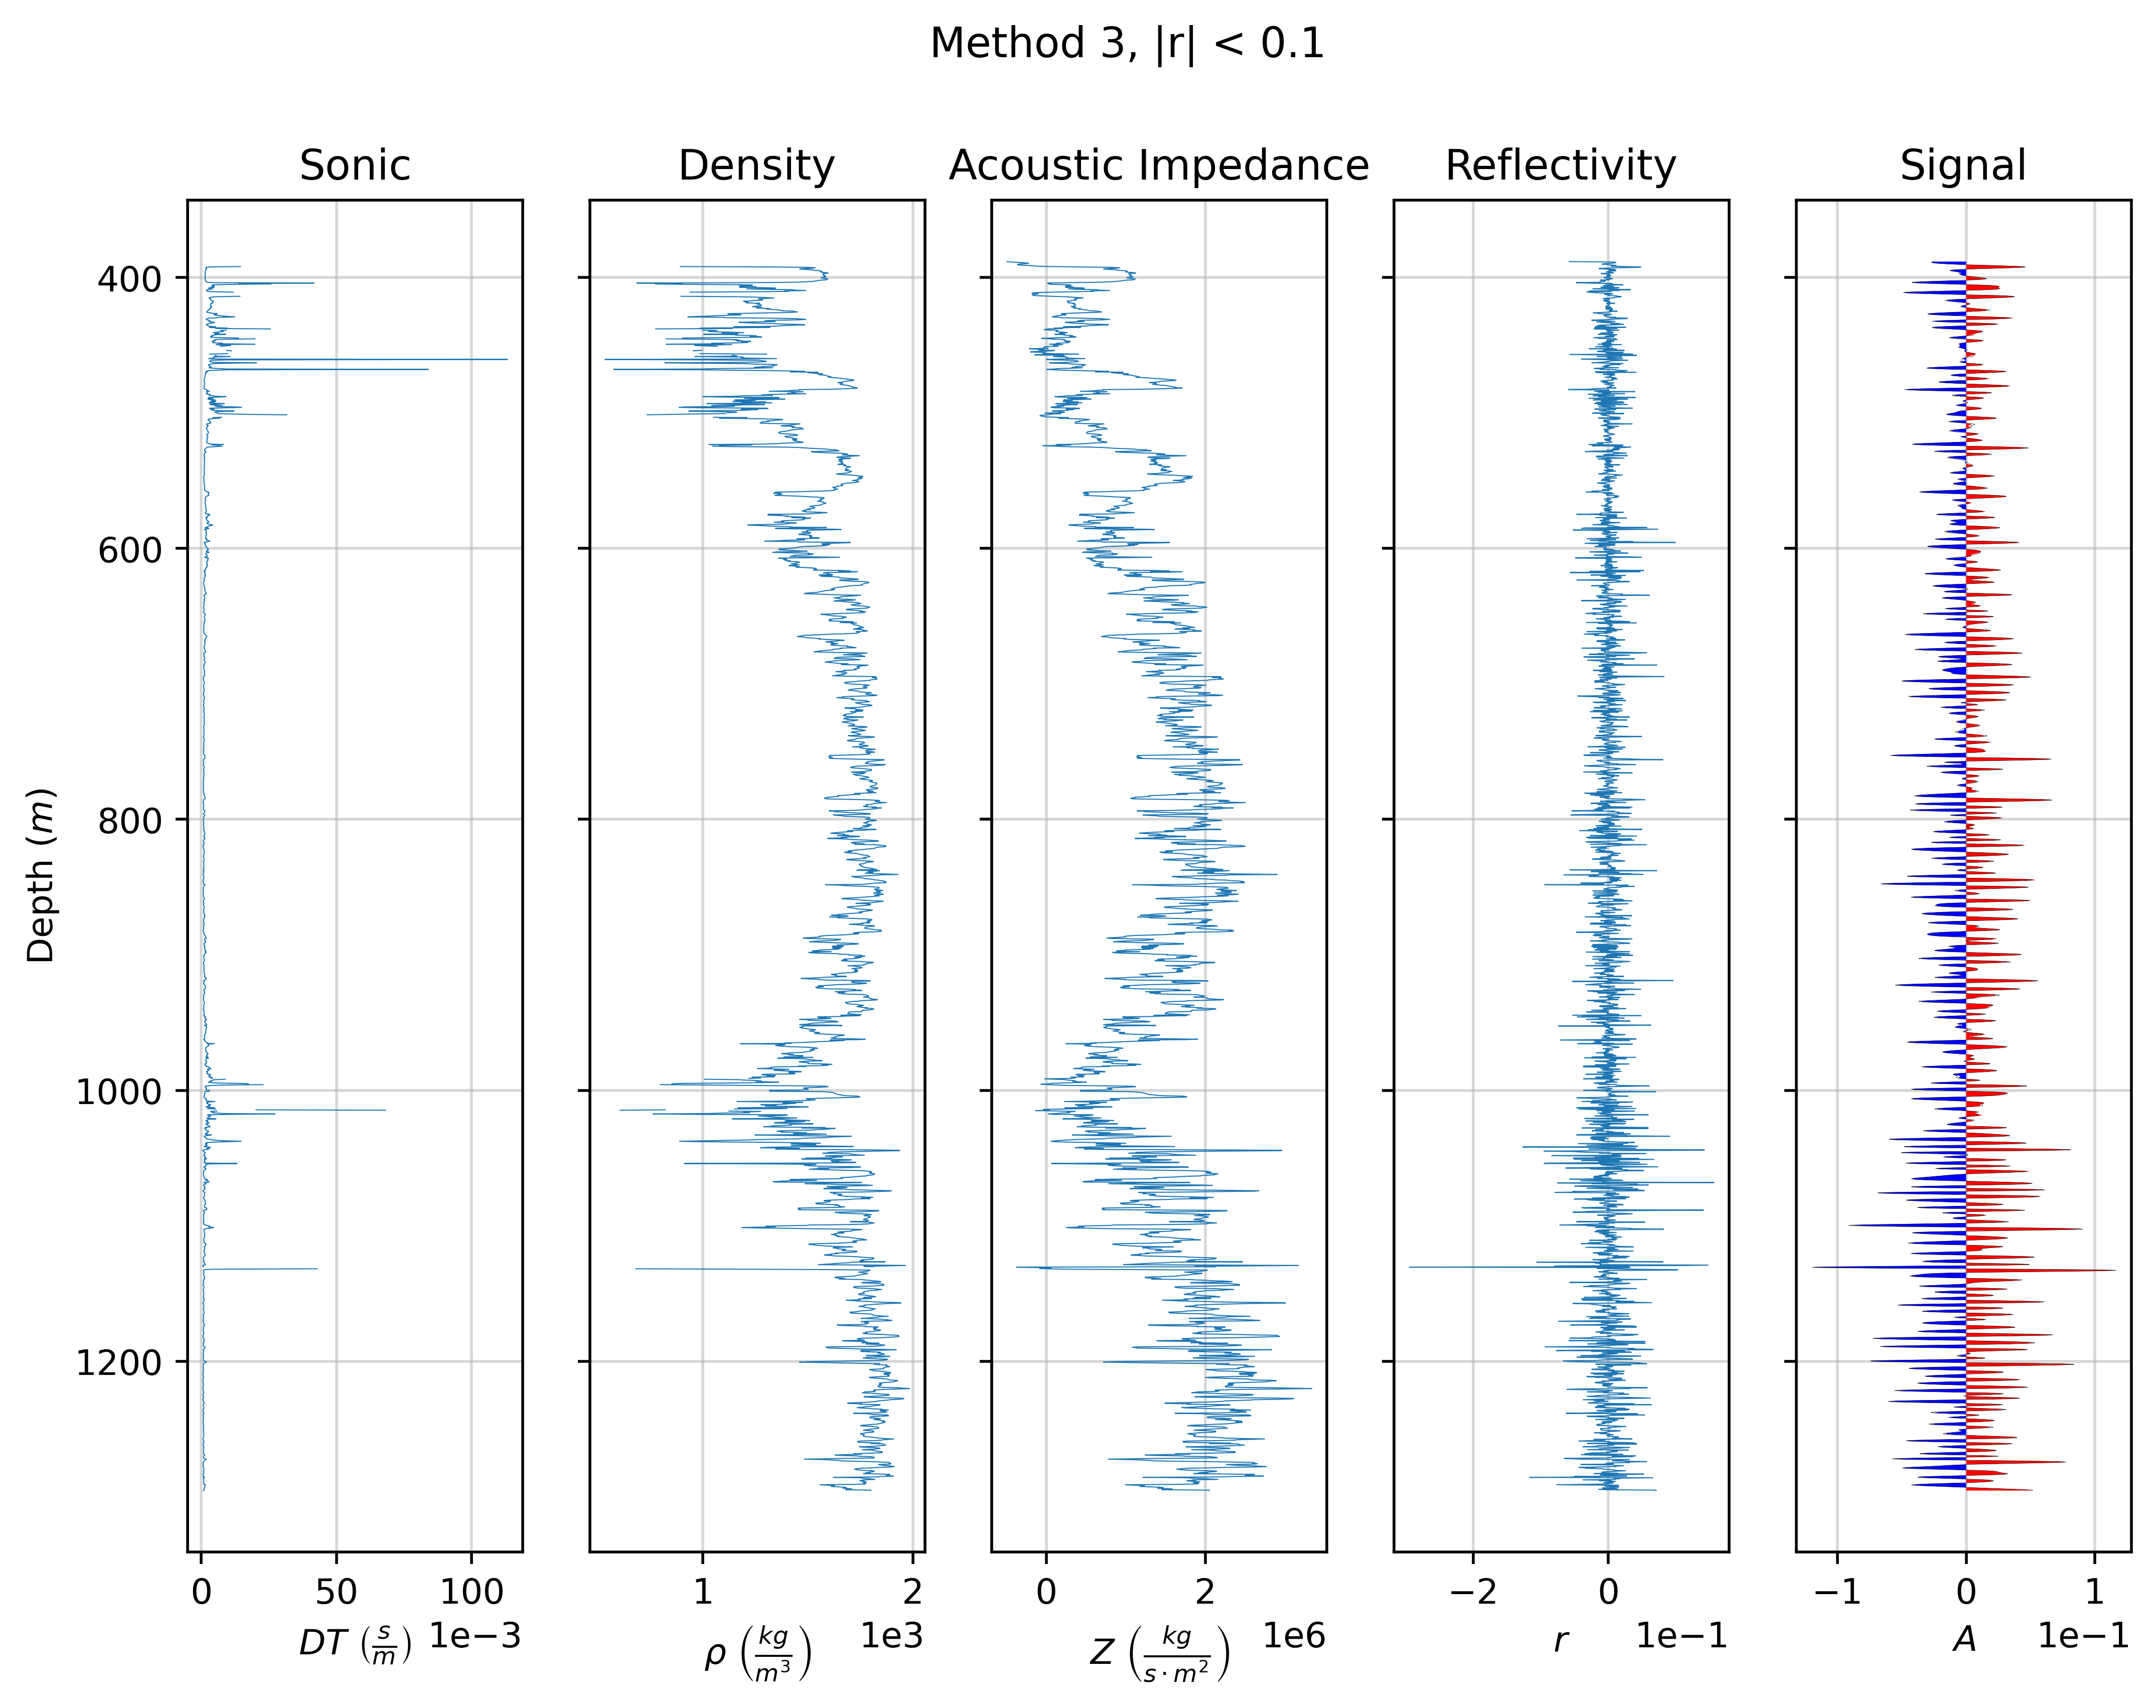

In [20]:
fig, ax = plt.subplots(1,5, figsize=(10,7), sharey=True, dpi=500)
lw=.3
ax[0].plot(1/df.Vp_m3, df.DEPT, linewidth=lw)
ax[0].set_xlabel(r'$DT$ $\left(\frac{s}{m}\right)$')
ax[0].set_ylabel(r'Depth ($m$)')
ax[0].grid(alpha=.5)
ax[0].invert_yaxis()
ax[0].set_axisbelow(True)
ax[0].ticklabel_format(style='sci', axis='x', scilimits=(-3,-3))

ax[1].plot(df.rho_m3, df.DEPT, linewidth=lw)
ax[1].set_xlabel(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
ax[1].grid(alpha=.5)
ax[1].set_axisbelow(True)
ax[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

ax[2].plot(df.Z_m3, df.DEPT, linewidth=lw)
ax[2].set_xlabel(r'$Z$ $\left(\frac{kg}{s \cdot m^2}\right)$')
ax[2].grid(alpha=.5)
ax[2].set_axisbelow(True) 
ax[2].ticklabel_format(style='sci', axis='x', scilimits=(6,6))

ax[3].plot(df.r_prim, df.DEPT, linewidth=lw)
ax[3].set_xlabel(r'$r$')
ax[3].grid(alpha=.5)
ax[3].set_axisbelow(True)
ax[3].ticklabel_format(style='sci', axis='x', scilimits=(-1,-1))

ax[4].plot(df.s_prim, df.DEPT, linewidth=.1, color='k')
ax[4].set_xlabel(r'$A$')
ax[4].grid(alpha=.5)
ax[4].set_axisbelow(True)
ax[4].fill_betweenx(df.DEPT, x1=df.s, x2=0, where=df.s<=0, color='blue', linewidth=0)
ax[4].fill_betweenx(df.DEPT, x1=df.s, x2=0, where=df.s>0, color='red', linewidth=0)
ax[4].ticklabel_format(style='sci', axis='x', scilimits=(-1,-1))

ax[0].set_title('Sonic')
ax[1].set_title('Density')
ax[2].set_title('Acoustic Impedance')
ax[3].set_title('Reflectivity')
ax[4].set_title('Signal')

plt.suptitle('Method 3, |r| < 0.1')

# Errors

In [21]:
# Method 1 errors
print('='*40, 'Error for method 1, Recursive approach', '='*40, '\n')
error_vp = np.mean((df.Vp_m1 - 1/df.DT)/(1/df.DT))*100
error_rho = np.mean((df.rho_m1 - df.RHOB)/(df.RHOB))*100
error_z = np.mean((df.Z_m1 - df.Z)/(df.Z))*100 
error_m1 = (error_vp+error_rho+error_z)/3
print(f'Error for Vp: {np.round(error_vp,2)} %')
print(f'Error for rho: {np.round(error_rho,2)} %')
print(f'Error for Z: {np.round(error_z,2)} %')
print(f'Overall error: {np.round(error_m1,2)} %')

# Method 2 errors
print('='*40, 'Error for method 2, |r| < 0.3', '='*40, '\n')
error_vp = np.mean((df.Vp_m2 - 1/df.DT)/(1/df.DT))*100
error_rho = np.mean((df.rho_m2 - df.RHOB)/(df.RHOB))*100
error_z = np.mean((df.Z_m2 - df.Z)/(df.Z))*100 
error_m1 = (error_vp+error_rho+error_z)/3
print(f'Error for Vp: {np.round(error_vp,2)} %')
print(f'Error for rho: {np.round(error_rho,2)} %')
print(f'Error for Z: {np.round(error_z,2)} %')
print(f'Overall error: {np.round(error_m1,2)} %')


# Method 3 errors
print('='*40, 'Error for method 3, |r| < 0.1', '='*40, '\n')
error_vp = np.mean((df.Vp_m3 - 1/df.DT)/(1/df.DT))*100
error_rho = np.mean((df.rho_m3 - df.RHOB)/(df.RHOB))*100
error_z = np.mean((df.Z_m3 - df.Z)/(df.Z))*100 
error_m1 = (error_vp+error_rho+error_z)/3
print(f'Error for Vp: {np.round(error_vp,2)} %')
print(f'Error for rho: {np.round(error_rho,2)} %')
print(f'Error for Z: {np.round(error_z,2)} %')
print(f'Overall error: {np.round(error_m1,2)} %')

======================================== Error for method 1, Recursive approach ======================================== 

Error for Vp: -0.89 %
Error for rho: -1.16 %
Error for Z: -2.0 %
Overall error: -1.35 %
======================================== Error for method 2, |r| < 0.3 ======================================== 

Error for Vp: -0.87 %
Error for rho: -1.15 %
Error for Z: -1.98 %
Overall error: -1.33 %
======================================== Error for method 3, |r| < 0.1 ======================================== 

Error for Vp: -70.52 %
Error for rho: -28.25 %
Error for Z: -78.68 %
Overall error: -59.15 %


We observed that only in the first two approaches (method 1 and method 2), $\rho$ and $v$ were correctly calculated with an error of less than 5%. On the other hand, the reflectivity profile, with values of $r$ greater than 0.2 (roughly at a depth of 1100m), did not allow method 3 to converge as expected, resulting in missing calculated values.

Method 1 does not require $r$ to be below a specific threshold value, while method 2 requires |r| < 0.3, a condition that is met. As a result, the first two methods yield a good recursive inversion result, whereas the third one does not meet the conditions for a successful outcome